<a href="https://colab.research.google.com/github/kaicque/Projeto-Final-Bootcamp-DS/blob/main/Notebooks/Tratamento_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook de tratamento de dados pré analise

## Importação das bibliotecas utilizadas no notebook:

In [16]:
# Importando Pandas para atribuir o dataset a uma variável.
import pandas as pd

# Importando o numpy.
import numpy as np

# Importando o LabelEncoder para categorizar os dados da dezena de idade
from sklearn.preprocessing import LabelEncoder

# matplotlib e seaborn para auxiliar na criação do gráfico comparativo de pacientes que foram ou não para UTI
import matplotlib.pyplot as plt
import seaborn as sns

# Retirada dos alertas
import warnings
warnings.filterwarnings('ignore')

## Criação de funções:

In [2]:
# Com essa função apliquei o metodo 'back' e 'foward' fill nas colunas de valores continuos, retornando ao final o dataset completo e aproveito para transformar a coluna "AGE_PERCENTIL" em dados categoricos.
def preenche_tabela_frente(dados):
    features_continuas_colunas = dados.iloc[:,13:-2].columns
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:,:13]
    saida = dados.iloc[:,-2:]
    dados_finais = pd.concat([features_categoricas,features_continuas,saida], ignore_index=True,axis=1)
    dados_finais.columns = dados.columns
    # Tratando os dados de dezena de idade em categorias
    set(dados_finais['AGE_PERCENTIL'])
    label_encoder = LabelEncoder()
    dados_finais['AGE_PERCENTIL'] = label_encoder.fit_transform(dados_finais['AGE_PERCENTIL'])
    return dados_finais

In [3]:
# Função para filtrar a primeira hora de todos os paciente e assinalando que ele pode ter ido pra UTI em seguida.
def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

In [4]:
# Função para verificar quantidade de dados nulos a base possue
def verifica_nulos(dados):
  dados_faltantes = pd.DataFrame()
  dados_faltantes['nulos']  = data=dados.isnull().sum()
  dados_faltantes['perc_dados_faltantes'] = (dados_faltantes["nulos"]/dados.shape[0])*100
  dados_faltantes = dados_faltantes.sort_values('perc_dados_faltantes',ascending=False)
  return dados_faltantes

In [5]:
#Função para remoção de colunas com multicolinearidade
def remove_corr_var(dados,valor_corte):
  
  matrix_corr = dados.iloc[:,4:-2].corr().abs()
  matriz_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape),k=1).astype(np.bool))
  excluir = [coluna for coluna in matriz_upper if any(matriz_upper[coluna] > valor_corte)]

  return dados.drop(excluir,axis=1)

## Importação dos dados originais:

In [6]:
# Importando a planilha original do Kaggle, criando e visualizando o dataset.
dados = pd.read_excel('https://github.com/kaicque/Projeto-Final-Bootcamp-DS/raw/main/Dados/Original/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')
# Exibindo os tipos de dados existentes e quantidade de entradas
dados.info()
# Exibindo os primeiros dados
dados.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

Logo na exibição dos primeiros dados, verificamos alguns valores nulos. Então já deixamos o alerta ligado para verificar quantos dados que faltam.

Para isso criaremos um novo dataset para ter uma ideia de qual o % dos dados estão nulos

In [7]:
#Criação do data framme dados faltantes para verificar a quantidade de colunas que tem pelo menos 30% de dados totais faltantes(Nulos/NA).
dados_faltantes = verifica_nulos(dados)
dados_faltantes.query('perc_dados_faltantes > 30')

,nulos,perc_dados_faltantes
P02_VENOUS_MIN,1104,57.350649
LEUKOCYTES_MAX,1104,57.350649
PC02_VENOUS_MEAN,1104,57.350649
PC02_VENOUS_MIN,1104,57.350649
PC02_VENOUS_MAX,1104,57.350649
...,...,...
BLOODPRESSURE_DIASTOLIC_MEDIAN,685,35.584416
HEART_RATE_MEAN,685,35.584416
BLOODPRESSURE_SISTOLIC_MEAN,685,35.584416
BLOODPRESSURE_DIASTOLIC_MEAN,685,35.584416


Com essa tabela verificamos que temos 216 colunas com pelo menos 30% de dados nulos, e o maior percentual fica na casa dos 57%. 

Então precisaremos de uma ação para tratamento desses dados.

## Tratamento dos dados:

### Preenchiento dos dados faltantes:

Verificando a documentação do desafio, os dados faltantes era um problema conhecido e fica explicitado na seguinte frase que pode ser encontrada no [Kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19) :

* "***It is reasonable to assume that a patient who does not have a measurement recorded in a time window is clinically stable, potentially presenting vital signs and blood labs similar to neighboring windows.***"

Logo podemos preencher os dados faltantes com os dados de janelas anteriores ou posteriores, o que já é uma sugestão do desafio. 

Por tanto, imaginando que o dado vazio supõe que não houve alteração da medida anterior, adotei como premissa preencher os dados vazios com informações da entrada anterior e, quando a condição não se aplicar, puxando dado posteriores. 

In [8]:
#Criando um novo dataset com os dados preenchidos 
dados_preenchidos = preenche_tabela_frente(dados)
dados_preenchidos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.0,1925.000000,1925.000000,1925.000000,1925.000000,1925.0,1925.000000,1925.000000,1925.000000,1925.000000,1925.0,1925.000000,1925.000000,1925.000000,1925.000000,1925.0,1925.000000,1925.000000,1925.000000,1925.000000,1925.0,1925.000000,1925.000000,...,1925.000000,1925.000000,1925.0,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000
mean,192.000000,0.467532,4.319481,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,0.158333,0.809896,0.516213,0.516213,0.516213,0.516213,-1.0,-0.955636,-0.955636,-0.955636,-0.955636,-1.0,-0.925260,-0.925260,-0.925260,-0.925260,-1.0,-0.306151,-0.306151,-0.306151,-0.306151,-1.0,-0.306658,-0.306658,-0.306658,-0.306658,-1.0,-0.946290,-0.946290,...,-0.954853,-0.954853,-1.0,-0.080520,-0.333571,-0.264856,-0.443451,0.066566,0.747798,-0.084355,-0.338761,-0.268233,-0.437976,0.063237,0.752317,-0.012805,-0.189747,-0.246780,-0.462931,0.343399,0.837630,-0.246878,-0.420799,-0.306649,-0.355907,-0.013680,0.810841,-0.788196,-0.769867,-0.795555,-0.758319,-0.811824,-0.910237,-0.817464,-0.758728,-0.848568,-0.771306,-0.812740,-0.910107,0.267532
std,111.168431,0.499074,2.867348,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,0.365148,0.392485,0.235482,0.235482,0.235482,0.235482,0.0,0.180870,0.180870,0.180870,0.180870,0.0,0.178368,0.178368,0.178368,0.178368,0.0,0.107166,0.107166,0.107166,0.107166,0.0,0.121658,0.121658,0.121658,0.121658,0.0,0.085186,0.085186,...,0.121905,0.121905,0.0,0.251287,0.269114,0.242959,0.219027,0.244714,0.124261,0.257442,0.272648,0.248633,0.229689,0.252491,0.121534,0.276894,0.270700,0.264318,0.267036,0.211571,0.244061,0.252048,0.270569,0.278271,0.373856,0.267443,0.133631,0.335760,0.377467,0.335971,0.433037,0.296595,0.255396,0.301522,0.389168,0.246814,0.400915,0.295435,0.256035,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [9]:
# Verificando se o novo dataset ainda contém algum dado nulo
dados_faltantes = verifica_nulos(dados_preenchidos)
dados_faltantes.query('perc_dados_faltantes > 30')

,nulos,perc_dados_faltantes


Com os dados preenchidos, verificamos que temos 1925 linhas de dados de pacientes com 384 pacientes diferentes.

### Filtro dos dados utilizáveis:

Com o intuito de obter a resposta o mais breve possível para melhorar a tomada de decisão precisamos filtrar os dados em 2 etapas:
  * Tirar os paciêntes que foram para a UTI na primeira janela
  * E nos demais paciêntes, demarcar logo na primeira janela se ele foi para a UTI em janelas futuras e utilizar somente ela.

In [10]:
# Primeira etapa: tirar os pacientes que foram internados logo na primeira hora
a_remover = dados_preenchidos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_preenchidos = dados_preenchidos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
#dados_preenchidos = dados_preenchidos.dropna()
dados_preenchidos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1765.000000,1765.000000,1765.000000,1765.000000,1760.00000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.0,1765.000000,1765.000000,1765.000000,1765.000000,1765.0,1765.000000,1765.000000,1765.000000,1765.000000,1765.0,1765.000000,1765.000000,1765.000000,1765.000000,1765.0,1765.000000,1765.000000,1765.000000,1765.000000,1765.0,1765.000000,1765.000000,...,1765.000000,1765.000000,1765.0,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000
mean,192.835694,0.456091,4.266289,0.379603,0.11250,0.026136,0.101705,0.021591,0.132955,0.049432,0.212500,0.163636,0.828977,0.518160,0.518160,0.518160,0.518160,-1.0,-0.958504,-0.958504,-0.958504,-0.958504,-1.0,-0.927123,-0.927123,-0.927123,-0.927123,-1.0,-0.306460,-0.306460,-0.306460,-0.306460,-1.0,-0.305410,-0.305410,-0.305410,-0.305410,-1.0,-0.945915,-0.945915,...,-0.955341,-0.955341,-1.0,-0.073412,-0.339677,-0.267114,-0.458881,0.067995,0.747728,-0.077557,-0.344812,-0.269940,-0.452789,0.064984,0.751722,-0.001700,-0.187188,-0.243902,-0.469567,0.350609,0.841841,-0.248241,-0.432362,-0.312528,-0.382162,-0.017547,0.807828,-0.798951,-0.785502,-0.804139,-0.778337,-0.822811,-0.915604,-0.827971,-0.774383,-0.854506,-0.788237,-0.823775,-0.915560,0.201133
std,110.481302,0.498209,2.888209,0.485426,0.31607,0.159586,0.302345,0.145385,0.339622,0.216829,0.409193,0.370050,0.376636,0.234931,0.234931,0.234931,0.234931,0.0,0.182551,0.182551,0.182551,0.182551,0.0,0.178735,0.178735,0.178735,0.178735,0.0,0.107632,0.107632,0.107632,0.107632,0.0,0.120818,0.120818,0.120818,0.120818,0.0,0.088736,0.088736,...,0.125055,0.125055,0.0,0.248374,0.261040,0.241688,0.207537,0.239420,0.119848,0.254282,0.264150,0.247395,0.218481,0.247607,0.119869,0.269976,0.260834,0.259826,0.251848,0.192826,0.236465,0.246209,0.258445,0.274224,0.356454,0.262187,0.132190,0.322676,0.355667,0.324361,0.411332,0.276154,0.247344,0.287526,0.367897,0.240022,0.383863,0.274823,0.247742,0.400961
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

Logo com apenas a primeira etapa concluida, verificamos a quantidade de dados diminuir pelo filtro de pacientes que foram pra UTI na primeira janela.

In [11]:

# Segunda etapa: Filtrar apenas a primeira janela de todos os paciêntes e colocar se foram pra UTI ou não em qualquer janela do tempo.
dados_preenchidos = dados_preenchidos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_preenchidos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,353.000000,353.000000,353.000000,353.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,353.000000,353.000000,353.000000,353.000000,353.0,353.000000,353.000000,353.000000,353.000000,353.0,353.000000,353.000000,353.000000,353.000000,353.0,353.000000,353.000000,353.000000,353.000000,353.0,353.000000,353.000000,353.000000,353.000000,353.0,353.000000,353.000000,...,353.000000,353.000000,353.0,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,192.835694,0.456091,4.266289,0.379603,0.105114,0.022727,0.090909,0.019886,0.127841,0.042614,0.193182,0.161932,0.832386,0.576935,0.576935,0.576935,0.576935,-1.0,-0.997849,-0.997849,-0.997849,-0.997849,-1.0,-0.958501,-0.958501,-0.958501,-0.958501,-1.0,-0.318317,-0.318317,-0.318317,-0.318317,-1.0,-0.320252,-0.320252,-0.320252,-0.320252,-1.0,-0.945669,-0.945669,...,-0.955228,-0.955228,-1.0,-0.037525,-0.313538,-0.240751,-0.466909,0.108997,0.752296,-0.038681,-0.314666,-0.239617,-0.454918,0.107193,0.753765,0.107503,-0.087606,-0.143653,-0.390935,0.436354,0.896758,-0.312559,-0.499916,-0.383197,-0.504335,-0.076569,0.769644,-0.956497,-0.959923,-0.965962,-0.961673,-0.964185,-0.985178,-0.962087,-0.957925,-0.975893,-0.963973,-0.964688,-0.985201,0.461756
std,110.606778,0.498775,2.891489,0.485977,0.307136,0.149245,0.287889,0.139809,0.334388,0.202272,0.395356,0.368913,0.374055,0.134367,0.134367,0.134367,0.134367,0.0,0.024311,0.024311,0.024311,0.024311,0.0,0.114487,0.114487,0.114487,0.114487,0.0,0.032346,0.032346,0.032346,0.032346,0.0,0.089521,0.089521,0.089521,0.089521,0.0,0.044198,0.044198,...,0.141804,0.141804,0.0,0.264747,0.292891,0.277924,0.221720,0.269084,0.156495,0.268849,0.293767,0.285744,0.234702,0.274780,0.161218,0.235611,0.245818,0.252605,0.232891,0.165768,0.062885,0.186477,0.211540,0.225072,0.209541,0.229447,0.159207,0.113794,0.114892,0.096374,0.110501,0.088236,0.032784,0.107646,0.118875,0.060342,0.095302,0.086411,0.033170,0.499243
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.578947,-0.578947,-0.578947,-0.578947,-1.0,-1.000000,-1.000

Com a segunda etapa concluida, podemos observar uma quantidade menor de dados, que corresponde a apenas 1 linha por paciente. Essa abordagem foi utilizada para tentar antecipar o conhecimento de quais paciêntes podem ir pra UTI logo com o resultado do primeiro exame.

## Exclusão de colunas com multicolinearidade.

Nesta etapa, visamos reduzir redundâncias dos nossos futuros modelos de machine learning. Aplicando uma regua de corte de 0.95.

In [12]:
# Criação do dataset sem as colunas com multicolinearidade
dados_limpos_sem_corr = remove_corr_var(dados_preenchidos,0.95)

In [13]:
dados_limpos_sem_corr.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,...,PCR_DIFF,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,ICU
count,353.000000,353.000000,353.000000,353.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.0,...,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.0,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,192.835694,0.456091,4.266289,0.379603,0.105114,0.022727,0.090909,0.019886,0.127841,0.042614,0.193182,0.161932,0.832386,0.576935,-1.0,-0.997849,-1.0,-0.958501,-1.0,-0.318317,-1.0,-0.320252,-1.0,-0.945669,-1.0,-0.993597,-1.0,0.326704,-1.0,-0.892356,-1.0,-0.729211,-1.0,-0.936653,-1.0,-0.850286,-1.0,-0.107833,-1.0,-1.0,...,-1.0,0.232475,-1.0,0.382694,-1.0,-0.537294,-1.0,-0.567097,-1.0,0.926861,-1.0,0.288637,-1.0,-0.104816,-1.0,-0.993654,-1.0,-0.987264,-1.0,-0.836188,-1.0,-0.850206,-1.0,-0.955228,-1.0,-0.037525,-0.313538,-0.240751,-0.466909,0.108997,0.752296,-0.390935,-0.312559,-0.956497,-0.959923,-0.965962,-0.961673,-0.964185,-0.985178,0.461756
std,110.606778,0.498775,2.891489,0.485977,0.307136,0.149245,0.287889,0.139809,0.334388,0.202272,0.395356,0.368913,0.374055,0.134367,0.0,0.024311,0.0,0.114487,0.0,0.032346,0.0,0.089521,0.0,0.044198,0.0,0.107309,0.0,0.083793,0.0,0.096151,0.0,0.165161,0.0,0.131707,0.0,0.116446,0.0,0.218967,0.0,0.0,...,0.0,0.042342,0.0,0.095532,0.0,0.181382,0.0,0.168385,0.0,0.138693,0.0,0.326159,0.0,0.211582,0.0,0.017510,0.0,0.015018,0.0,0.049206,0.0,0.080665,0.0,0.141804,0.0,0.264747,0.292891,0.277924,0.221720,0.269084,0.156495,0.232891,0.186477,0.113794,0.114892,0.096374,0.110501,0.088236,0.032784,0.499243
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.578947,-1.0,-1.000000,-1.0,-1.000000,-1.0,-0.756098,-1.0,-1.000000,-1.0,-0.994767,-1.0,-1.000000,-1.0,-0.040816,-1.0,-0.974522,-1.0,-0.927505,-1.0,-0.997664,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,...,-1.0,-0.489362,-1.0,-0.090909,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.0,-0.828571,-1.0,-1.000000,-1.0,-0.999619,-1.0,-0.961853,-1.0,-0.971084,-1.0,-1.000000,-1.0,-0.654321,-0.938462,-0.830189,-0.954802,-0.571429,-1.000000,-1.000000,-0.760684,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,98.000000,0.000000,2.000000,0.000000,0.00000

Nesse ultimo tratamento, conseguimos visualizar uma redução na quantidade de colunas do dataset, passando a ter 99 colunas.

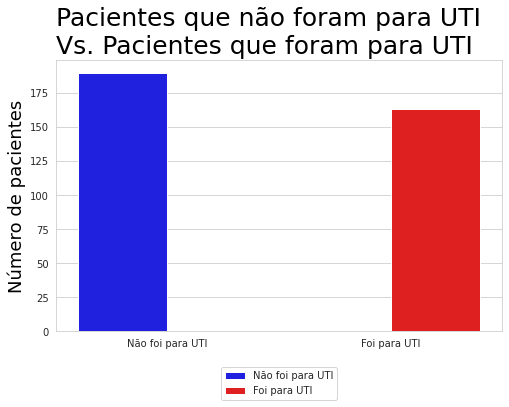

In [14]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize = (8, 5))
sns.countplot(dados_limpos_sem_corr['ICU'], hue=dados_limpos_sem_corr['ICU'], data=dados_limpos_sem_corr, palette=['b','r'], ax=ax)

plt.ylabel("Número de pacientes", fontdict = {'fontsize': 18}, color = '#000000')
plt.xlabel("", fontdict = {'fontsize': 20}, color = '#000000')
plt.title('Pacientes que não foram para UTI\nVs. Pacientes que foram para UTI',  loc = 'left', fontsize = 25, color = '#000000')

plt.legend(bbox_to_anchor=(1.00, 1), loc='upper right')
plt.legend(loc='center')
legend = plt.legend(loc='center')
plt.setp(legend.get_texts(), color='#30e327')
plt.legend(['Não foi para UTI', 'Foi para UTI'],loc='lower center', bbox_to_anchor=(0.50, -0.27))


fig.canvas.draw()

ax.set_xticklabels(['Não foi para UTI','Foi para UTI'])

plt.show()

# Observação sobre o dataset

Observando o dataset tratado, podemos ver que a distribuição dos paciêntes que foram ou não para UTI está bem próximo. Podemos considerar que tem baixa probabilidade do dataset ter algum vies relacionado a isso.

# Salvando o dataset tratado para aplicação na analise exploratória e no modelo de machine learning

In [15]:
dados_limpos_sem_corr.to_excel('dados_tratado.xlsx', index=False)